# Time Series Analysis

Zhentao Shi


* Practical topics
* Useful in business contexts
* Modeling choices and challenges

* Time Series Regression
* Univariate Time Series Models
* Nonstationary Time Series
* Multivariate Time Series

* Traditionally, small models
* High dimensional time series modeling is work in progress
* Predictive regression

### Common Operations

* Lag Operator

$$L x_t = x_{t-1}$$
$$L^{\tau} x_t = x_{t-\tau}$$ 

* Difference operator
$$\Delta x_t = x_t - x_{t-1} = (1-L) x_t$$

# Lagged Effect

* Interpretation as a generative model

$$y_t = \alpha + \sum_{i=0}^{\infty} \beta_i  x_{t-i} + e_t$$

* Impact multiplier: $\beta_0$
* Cumulated effect (of $\tau$ periods): $\sum_{i=0}^{\tau} \beta_i $
* Equilibrium multiplier: $\sum_{i=0}^{\infty} \beta_i $



# Stationary Time Series

For a univariate time series $(y_t)_{t= - \infty} ^ {\infty}$,
* **Strictly stationary**: joint distribution of any finite coordinate only depends on their relative position.
* **Weakly stationary**: the first two moments of any pair $y_t$ and $y_s$ only depends on their relative position.
    * $E[y_t] = \mu$ for all $t$
    * $\mathrm{var}[y_t] = \sigma^2$ for all $t$
    * $\mathrm{cov}[y_t, y_{t+\tau} ] $ only depends on $\tau$ independent of $t$



This notion can be extended to multiple-variate time series, for example $(y_t, x_t, e_t)$.

### Distributed Lags

* Lagged $x$ on the right-hand side

$$
y_t = \alpha + \sum_{i=0}^{\infty} \beta_i  x_{t-i} + e_t = \alpha + B(L) x_t + e_t 
$$

where $$B(L) = \sum_{i=0}^{\infty} \beta_i L^i$$ is a polynomial of the lag operators.

## Autoregressive model

* Lagged $y$ on the right-hand side

$$
y_t = \alpha + \sum_{i=1}^p \gamma_p y_{t-p} + e_t 
$$ 

can be written as 

$$
C(L) y_t = \alpha + e_t
$$ 

where 

$$
C(L) = 1 -\gamma_1 L - \cdots - \gamma_p L^p
$$ 

is a polynomial of the lag operators.

# Invertibility

If the roots of the polynomial equation $C(z) = 0$ **all** lies **outside** of the unit circle, we say the autoregressive model is invertible.



If $e_t$ is stationary with finite variance and $\alpha=0$ (homogenous difference equation):
* If the module of the smallest root is bigger than 1, $y_t$ is a stationary time series
* If the module of the smallest root is equal to 1, $y_t$ is a **unit root** process
* If the module of the smallest root is smaller than 1, $y_t$ is an **explosive** process


### Numerical Example

* $C(L) = 1 - 0.5L$ is invertible.
* $C(L) = 1 - L$ is non-invertible.
* $C(L) = 1 - 1.1L$ is non-invertible.

In [11]:
AR = function(b,T){
    y = rep(0,T)
    for (t in 1:T){
        if (t > 1) {
            y[t] = b * y[t - 1] + rnorm(1)
        }
    }
    return(ts(y) )
}

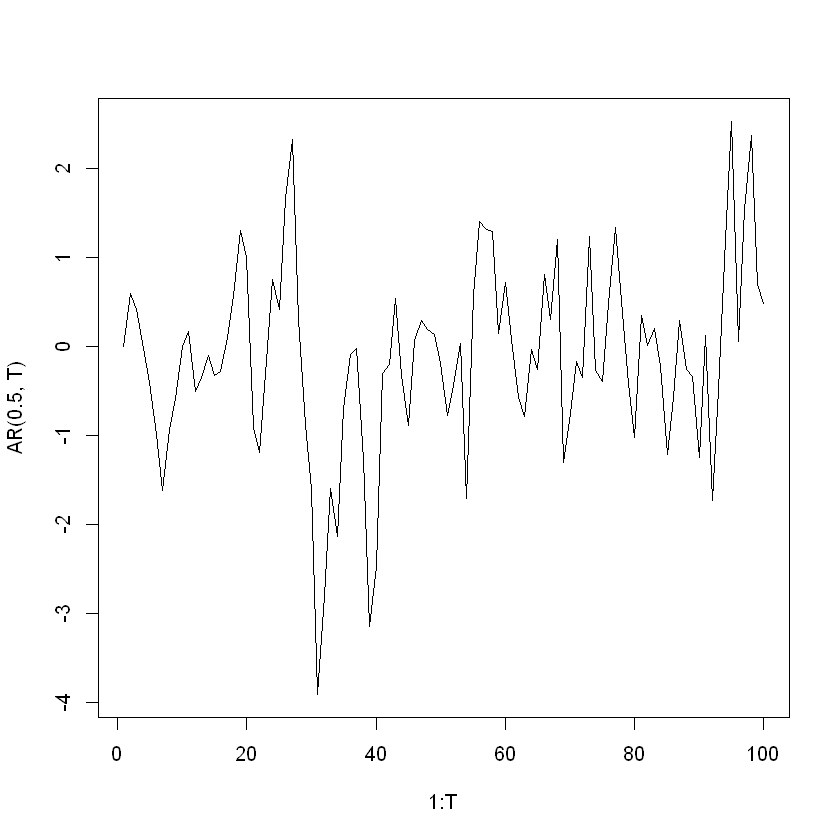

In [12]:
T = 100; plot( x = 1:T, y = AR(0.5, T), type = "l")

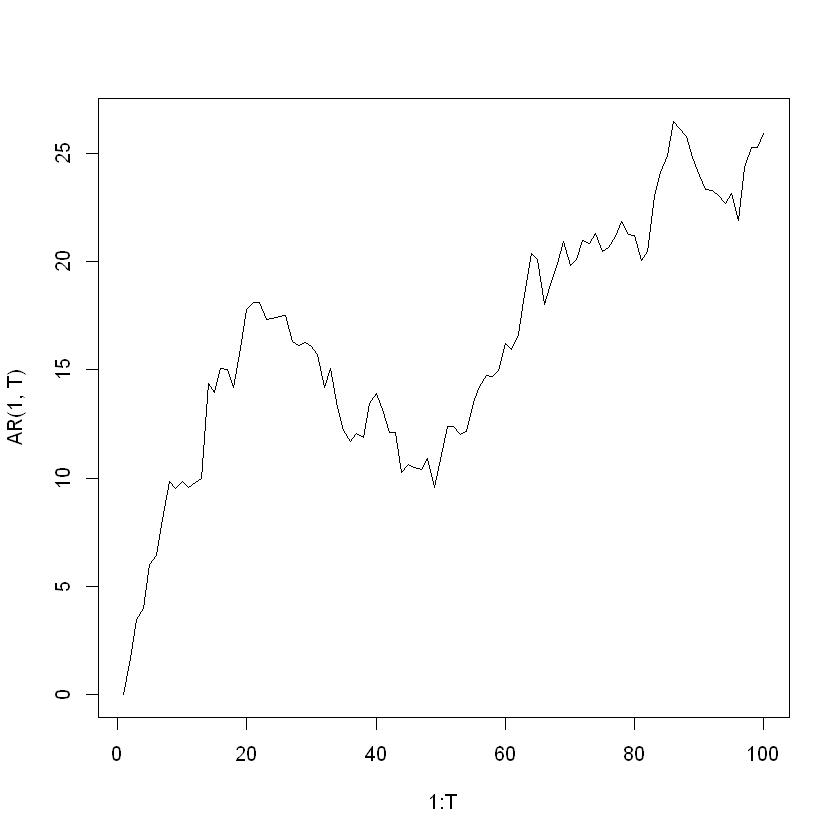

In [13]:
T = 100; plot( x = 1:T, y = AR(1.0, T), type = "l")

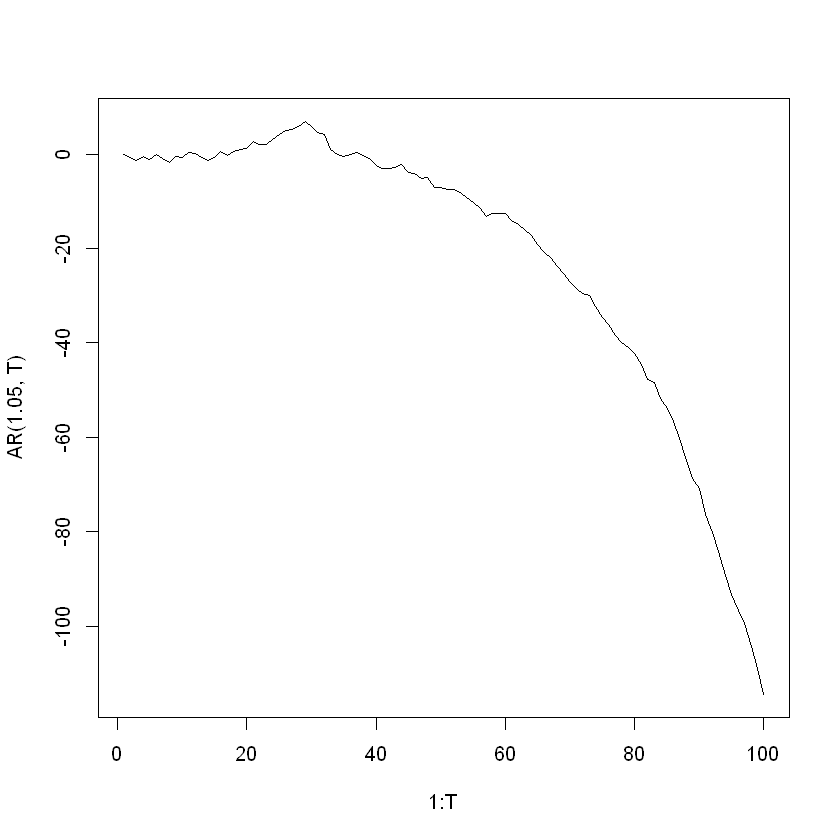

In [14]:
T = 100; plot( x = 1:T, y = AR(1.05,T), type = "l")

### Autoregressive Distributed Lag Models


* ARDL(p,r) model:

$$
C(L) y_t = \mu + B(L) x_t + e_t 
$$ 

where 

$$
C(L) = 1 -\gamma_1 L - \cdots - \gamma_p L^p
$$

and 

$$
B(L) =  \beta_0 + \beta_1 L + \cdots + \beta_r L^r.
$$

* **Granger causality**: 

$$
\beta_0 = \beta_1 = \cdots = \beta_r = 0
$$

### Example

* In simple regression form

$$
y_t = \beta_1 + \beta_2 x_t + \beta_3 x_{t-1} + \gamma y_{t-1} + e_t
$$

* Temporal lags of effect. eg: policy lag
* Expectation formed from the past. eg: forecast
* Explicitly depends on history. eg: wealth accumulation


In [6]:
library(tidyverse)

quantmod::getSymbols.FRED(Symbols = "POILBREUSDQ", env = .GlobalEnv) # Brent Oil price
quantmod::getSymbols.FRED(Symbols = "IPB50001SQ", env = .GlobalEnv) # industrial Index (quarterly data)

d0<- merge(POILBREUSDQ, IPB50001SQ, retclass = "data.frame") %>% 
  filter(!is.na(POILBREUSDQ)) %>%
  mutate( x = ts(POILBREUSDQ), y = ts(IPB50001SQ))

rm(POILBREUSDQ, IPB50001SQ)
print(head(d0))


[1] "POILBREUSDQ"

[1] "IPB50001SQ"

           POILBREUSDQ IPB50001SQ        x       y
1990-01-01    19.71918    62.2551 19.71918 62.2551
1990-04-01    16.38344    62.6975 16.38344 62.6975
1990-07-01    26.35708    62.9501 26.35708 62.9501
1990-10-01    32.36676    61.9831 32.36676 61.9831
1991-01-01    20.94640    60.8136 20.94640 60.8136
1991-04-01    18.90951    61.1649 18.90951 61.1649


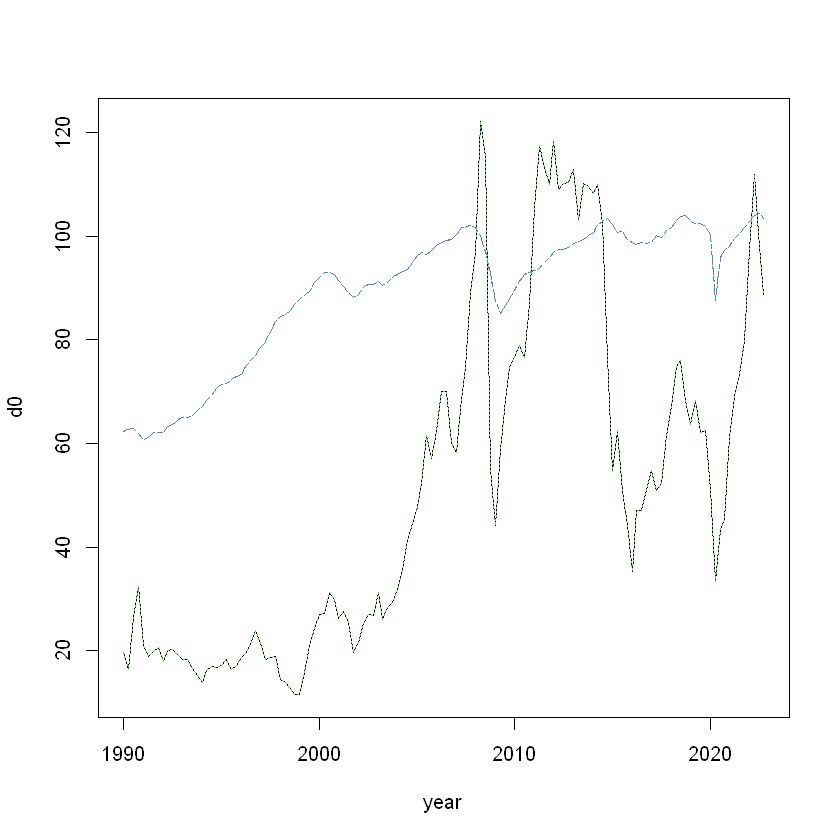

In [8]:
matplot(y = d0, 
        x = as.Date(row.names(d0), "%Y-%m-%d"), 
        main = "", type = "l", xlab = "year")

### ARDL(1,1) regression example

* `dynlm` only works with ojects `ts()`. The transformation is essential

In [9]:
dynlm::dynlm( y ~ L(y, c(1) ) + L(x,c(0:1) ), data = d0 )  %>%
      summary( )


Time series regression with "ts" data:
Start = 2, End = 132

Call:
dynlm::dynlm(formula = y ~ L(y, c(1)) + L(x, c(0:1)), data = d0)

Residuals:
     Min       1Q   Median       3Q      Max 
-11.3122  -0.4186   0.1981   0.7579   7.1331 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)    2.39560    1.11216   2.154   0.0331 *  
L(y, c(1))     0.97443    0.01436  67.862  < 2e-16 ***
L(x, c(0:1))0  0.07291    0.01536   4.747 5.47e-06 ***
L(x, c(0:1))1 -0.06964    0.01548  -4.500 1.52e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.578 on 127 degrees of freedom
Multiple R-squared:  0.9855,	Adjusted R-squared:  0.9851 
F-statistic:  2874 on 3 and 127 DF,  p-value: < 2.2e-16


* Differenced dependent variable (`d( )`)

In [15]:
dynlm::dynlm( d(y) ~ L(y, c(1) ) + L(x,c(0:1) ), data = d0 )  %>%
      summary( )


Time series regression with "ts" data:
Start = 2, End = 132

Call:
dynlm::dynlm(formula = d(y) ~ L(y, c(1)) + L(x, c(0:1)), data = d0)

Residuals:
     Min       1Q   Median       3Q      Max 
-11.3122  -0.4186   0.1981   0.7579   7.1331 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)    2.39560    1.11216   2.154   0.0331 *  
L(y, c(1))    -0.02557    0.01436  -1.781   0.0773 .  
L(x, c(0:1))0  0.07291    0.01536   4.747 5.47e-06 ***
L(x, c(0:1))1 -0.06964    0.01548  -4.500 1.52e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.578 on 127 degrees of freedom
Multiple R-squared:  0.1726,	Adjusted R-squared:  0.1531 
F-statistic: 8.833 on 3 and 127 DF,  p-value: 2.313e-05



# Spurious Regression


* The two time series $\{y_t\}$ and $\{x_t\}$ are generated independently, so that $E[y_t|x_t] = 0$. 
* However, we observe a high $R^2$ and large t-value if we regression $y_t$ against $x_t$.


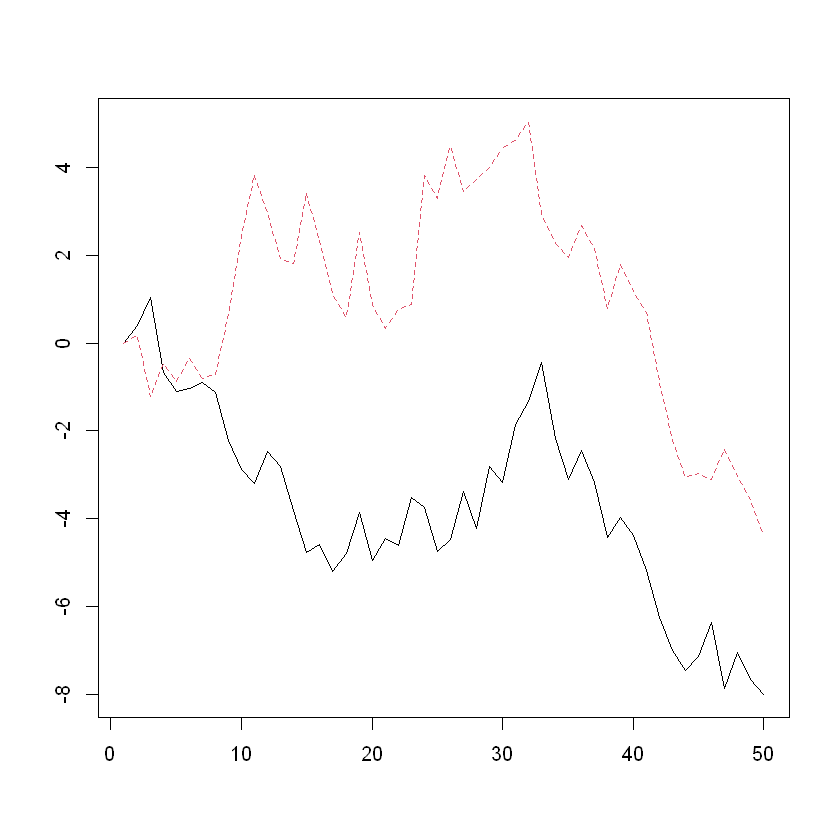

In [17]:
T = 50
a = 1

y <- AR(a, T)
x <- AR(a, T)
matplot( cbind(y, x), type = "l", ylab = "" )

In [18]:
reg <- lm(y ~ x)
summary(reg)


Call:
lm(formula = y ~ x)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.7963 -1.5099 -0.6195  0.5792  5.6041 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -4.1002     0.3150 -13.016  < 2e-16 ***
x             0.3952     0.1216   3.251  0.00211 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.056 on 48 degrees of freedom
Multiple R-squared:  0.1805,	Adjusted R-squared:  0.1634 
F-statistic: 10.57 on 1 and 48 DF,  p-value: 0.002106


### Discovery

* Granger and Newbold (1974): If we naively use 1.96 as the critical value for the $t$-ratio, how often we would reject the null hypothesis that $\beta = 0$?  

* The nominal asymptotic test size is $5\%$ according to the standard asymptotic theory
* The empirical size is about 0.80 in this simulation
* The drastic deviation suggests that the standard asymptotic theory fails in the nonstationary environment.


In [19]:
spurious <- function(i, a, T){
    y <- AR(a, T)
    x <- AR(a, T)
    
    reg <- lm(y ~ x)
    p.val <- summary(reg)[[4]][2,4]
    # save the p-value of the estimate of x's coefficient
    return(p.val)
}

library("plyr")
out <- ldply(.data = 1:1000, .fun = spurious, a = 1.0 , T = 100)
print( mean(out < 0.05) )

------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attaching package: 'plyr'


The following objects are masked from 'package:dplyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following object is masked from 'package:purrr':

    compact




[1] 0.752


### Autoregression and Moving Average

* Box-Jenkins (1976): ARMA
* No economic theory. For fitting and prediction only.

# A Simple Models

* White noise: $(e_t)_{t=-\infty}^{\infty}$:
    * $E[e_t] = 0$, $E[e_t^2] = \sigma_e^2$, and $E[e_t, e_s] = 0$ for all $t\neq s$. 

# ARMA


* AR(p) $$ y_t = \mu + \gamma_1 y_{t-1} + \cdots \gamma_p y_{t-p} + e_t $$
* MA(q) $$ y_t = \mu + e_t - \theta_1 e_{t-1} - \theta_q e_{t-q} + e_t $$
* ARMA(p,q) $$(1-\Gamma(L) ) y_t = \mu + \Theta (L) e_t$$

Stationarity: in AR form whether all roots lies out of the unit cycle.

# Autocorrelation Pattern


* MA(q): finite dependence
* AR(1): geometric decline
    * $E[ y_t ] = \mu / (1-\gamma_1)$
    * $\mathrm{var}[y_t] = \sigma_e^2 / (1-\gamma_1^2 )$
    * $E[ y_t | y_{t-1} ] = \mu + \gamma_1 y_{t-1}$
    * $\mathrm{var}[y_t | y_{t-1} ] = \sigma_e^2 $
    


# Modeling

* ARIMA(p, r, q) $$(1-\Gamma(L) ) \Delta^r y_t = \mu + \Theta (L) e_t$$
* Transform into stationary time series by taking logarithm and/or difference.
* Fit ARMA(p,q)

# Seasonality

* Generated due to sampling frequency
* Add dummies to control seasonality

# Estimation

* MLE for MA(q)
* MLE for ARMA(p,q)
* OLS for AR(p)

# Model Choice

Information criteria. 

Let $k$ be the total number of slope coefficient in the model.

* Akaike information criterion: $\log( \hat{\sigma}^2 ) + 2\times (k / T )$. 
    * Tend to overfit, but better for prediction
* Bayesian information criterion: $\log( \hat{\sigma}^2 ) + \log(T) \times (k / T )$
    * Model selection consistent
    
Information criteria are not restricted to time series regressions. They are general statistical measures for model/variable selection.

# Unit Root

* AR(1) with AR coefficient equals 1. $$y_t = \mu + y_{t-1} + e_t $$
* Nonstationary
* Brownian motion: normal innovation
* Random walk

## Implication
* conditional and unconditional mean
* conditional and unconditional variance
* $h$-period ahead forecast

The OLS estimator 

$$ 
T( \hat{\gamma}_1 - 1 ) \stackrel{d}{\to} \mbox{ a stable distribution}.
$$

but the asymptotic distribution is not normal. 

In [ ]:
library(quantmod, quietly = TRUE)
getSymbols("^GSPC") # S&P 500

y = GSPC$GSPC.Close
plot(y, type = "l")

tail(y)

* Null hypothesis: unit root.
$$ \Delta y_t = \mu + (\gamma_1 - 1 ) y_{t-1} + e_t = \mu+ \theta y_{t-1} + e_t$$
where $ \theta = \gamma_1 - 1 $. Under the null, $\theta = 0$.

* The $t$-statistic is the test statistic for the Dicky-Fuller test.
* Under the null, the $t$-statistic asymptotically follows a pivotal distribution.


* In this numerical example, the test does not reject the null.

Notice: the test is one-sided.

In [14]:
library(urca) # package for unit root and cointegration
print( summary(ur.df(y, type = "drift", lags = 0) ) ) # y here is the S&P 500 index
# the test does not reject the null of "unit root"
# loosely speaking, it is evidence in support of random walk

Warning message:
"package 'urca' was built under R version 4.2.3"



############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression drift 


Call:
lm(formula = z.diff ~ z.lag.1 + 1)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.60801 -0.54973  0.07856  0.69078  2.46568 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)  0.92862    0.36138   2.570   0.0134 *
z.lag.1     -0.09966    0.04633  -2.151   0.0366 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.008 on 47 degrees of freedom
Multiple R-squared:  0.08964,	Adjusted R-squared:  0.07027 
F-statistic: 4.628 on 1 and 47 DF,  p-value: 0.03663


Value of test-statistic is: -2.1513 3.435 

Critical values for test statistics: 
      1pct  5pct 10pct
tau2 -3.58 -2.93 -2.60
phi1  7.06  4.86  3.94



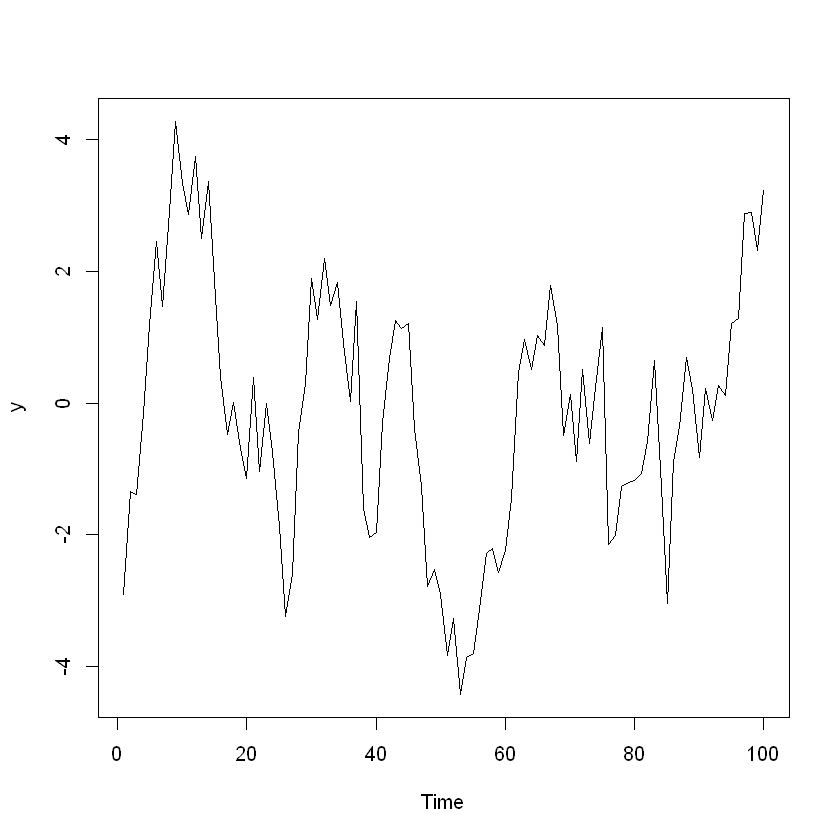

In [15]:
y = arima.sim( model = list(ar =.8), n = 100)
plot(y)


In [16]:
library(urca); summary( ur.df( y, type = "none", selectlags = "AIC" ) ) # , 


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression none 


Call:
lm(formula = z.diff ~ z.lag.1 - 1 + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-3.10385 -0.67933 -0.05143  0.89266  1.83314 

Coefficients:
           Estimate Std. Error t value Pr(>|t|)  
z.lag.1    -0.15151    0.05921  -2.559   0.0121 *
z.diff.lag -0.01732    0.10184  -0.170   0.8653  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.061 on 96 degrees of freedom
Multiple R-squared:  0.07172,	Adjusted R-squared:  0.05238 
F-statistic: 3.709 on 2 and 96 DF,  p-value: 0.02809


Value of test-statistic is: -2.5587 

Critical values for test statistics: 
     1pct  5pct 10pct
tau1 -2.6 -1.95 -1.61


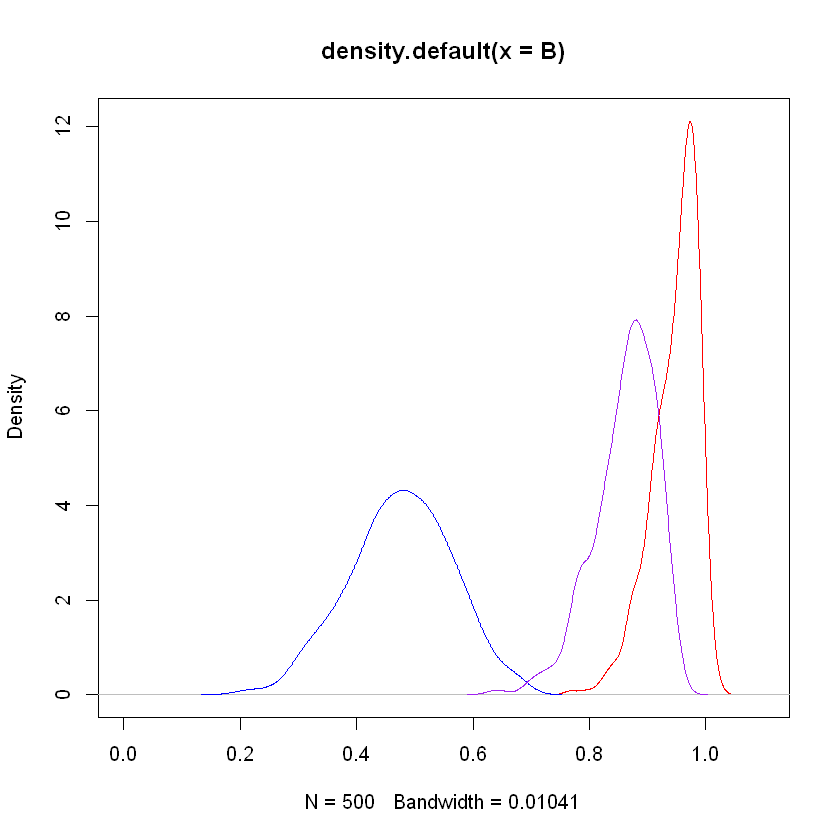

In [17]:
library(dynlm)

DF.sim = function(ar){
  Rep = 500
  n = 100
  
  B.hat = rep(0, Rep)
  
  for (r in 1:Rep){
    if (ar < 1) {
      y = arima.sim( model = list(ar = ar), n = n)
    } else if (ar == 1){
      y = ts( cumsum( rnorm(n) ) )
    }
    reg.dyn = dynlm( y ~ L(y,1) )
    B.hat[r] = coef(reg.dyn)[2]
  }
  return(B.hat)
  print("simulation is done with ar = ", ar, "\n")
}


B = DF.sim(1)
plot(density(B), col = "red", xlim = c(0, 1.1))

B = DF.sim(0.5)
lines(density(B), col = "blue")

B = DF.sim(0.9)
lines( density(B), col = "purple" )


## Specification of DF test

* The error term must be a white noise for the DF distribution
* DF test's critical values vary with the specfication of drift and/or trend
* Augmented Dicky-Fuller test: add more differenced lag terms

## Other tests
* Phillips-Perron test
* KPSS test

# Time Series Filtering

**Hodrick-Prescott filter**: Decompose a time series into *trend* and *cycle*

$$\hat{f}_{t}=\arg \min_{f_{t}}\left\{ \sum_{t=1}^{n}\left( y_{t}-f_{t}\right)^{2}+\lambda \sum_{t=3}^{n}\left( \Delta ^{2}f_{t}\right) ^{2}\right\}.$$
    
Hodrick Prescott (1980, 1997) suggest $\lambda = 1600$ for quarterly data.
$\lambda = 1600$ is also the base of adjustment for different time series data frequency.

In [ ]:
library(mFilter)
data(unemp)

unemp.hp <- hpfilter(unemp)
plot(unemp.hp)

# Boosted HP Filter

* Phillips and Shi (2019): "[Boosting: Why You Can Use the Hodrick-Prescott Filter](http://arxiv.org/abs/1905.00175)," arXiv: 1905.00175
* Chen and Shi (2019): R package **[BoostedHP](https://github.com/chenyang45/BoostedHP)**

# Cointegration

In a regression
$$y_t = \beta x_t  + e_t$$

* If $y_t$ and $x_t$ are I(1) series
* But a linear combination $e_t = y_t - \beta x_t $ is I(0)

then we say $y_t$ and $x_t$ are cointegrated.

In [ ]:
data(denmark)

period: Time index from 1974:Q1 until 1987:Q3.
* `LRM`	Logarithm of real money, M2.
* `LRY`	Logarithm of real income.
* `LPY`	Logarithm of price deflator.
* `IBO`	Bond rate.
* `IDE`	Bank deposit rate.

In [ ]:
sjd <- denmark[, c("LRM", "LRY", "IBO", "IDE")]
matplot(sjd[,c(3,4)], type = "l") # Bond rate vs Bank deposit rate

In [ ]:
y = sjd[,3]; x = sjd[,4]
reg = lm(y~x)
plot(residuals(reg), type = "l")
abline( h = 0, lty = 2)

# Source of Cointegration

Common shock is the source of cointegration

For example, if $y_{1t} = \mu_1 + \beta_1 t + e_{1t}$ and $y_{2t} = \mu_2 + \beta_2 t + e_{2t}$, where $e_{1t}$ and $e_{2t}$ are two white noises, then the cointegration vector must be $(1,\theta)$ where $$\theta = - \beta_1 / \beta_2.$$ The first coefficient 1 in this cointegration vector is for normalization.

In this example, the common trend is a determistic one. In other examples, they can also share a stochastic trend.

# Cointegration 

More generally, for an $m$-vector $y_t$ is cointegrated if there exists a parameter vector $\gamma$ (normalize the first element to be 1) such that $y_t ' \gamma$ is I(0).



* The number of linear independent cointegrated vectors is called the **cointegration rank**. 
* The cointegration rank arranges from 1 to $m-1$.

# Error Correction Model

Cliver Granger (Nobel prize 2001)

Consider an ARDL(1,1) model
$$ y_t  = \mu + \beta_0 x_t + \beta_1 x_{t-1} + \gamma_1 y_{t-1} + e_t. $$
If $\beta_0 = \beta_1 = 0$, no *Granger causality* between $X$ and $Y$.
When $X$ and $Y$ are both nonstationary, standard OLS inference is invalid.

Subtract $y_{t-1}$ from both sides of 
$$
\begin{align*}
\Delta y_t & = \mu + \beta_0 x_t + \beta_1 x_{t-1} + (\gamma_1 -1 ) y_{t-1} + e_t  \\
           & = \mu + \beta_0 \Delta x_t + (\beta_1 + \beta_0) x_{t-1} + (\gamma_1 -1 ) y_{t-1} + e_t  \\
           & = \mu + \beta_0 \Delta x_t + (\gamma_1 -1 )( y_{t-1} - \theta x_{t-1} ) + e_t  
\end{align*}
$$
where $\theta =  (\beta_1 + \beta_0)/(1 - \gamma_1)$.

* A short-run relationship $\Delta y_t \sim \mu + \beta_0 \Delta x_t + e_t$.
* An long-run equilibrium error $(\gamma_1 - 1 ) (y_{t-1} - \theta x_{t-1} ) $.



When $y_t$ is nonstationary


* First difference recovers stationarity
* Useful to identify spurious regression
* Can be estimated either by OLS or by NLS

# Predictive Regression

In the regression 

$$
y_t = \mu_y + \beta_1 x_{t-1} + e_{yt}
$$

* $y_t$ is stationary 
* The predictor $x_t$ is highly persistent:

$$
x_t = \mu_x + \gamma x_{t-1} + e_{xt}
$$ 

with $\gamma$ is close to 1.

* Even if $E[e_{yt} | x_{t-1} ] = 0$, OLS estimator of $\beta_1$ is biased in finite sample when $e_{yt}$ and $e_{xt}$ are correlated (Stambaugh, 1999).

* Lee, Shi and Gao (2018): "[On LASSO for Predictive Regression](https://arxiv.org/abs/1810.03140)," arXiv: 1810.03140
* Find new behavior of popular machine learning methods in predictive regression.

# Vector Autoregression (VAR)

Christopher Sims (Nobel Prize 2011)

An $m$-equation system
$$ y_t = \mu + \Gamma_1 y_{t-1} + \cdots + \Gamma_p y_{t-p} + v_t $$
where $E[ v_t v_t'] = \Omega$.

For prediction purpose, as a reduced-form of structural simultaneous equations.

### Estimation

* For consistency and asymptotic normality, use OLS equation by equation
* For asymptotic efficient, use multiple-equation GLS



# Invertibility

Write the VAR(p) as
$$ (I_m - \Gamma (L) ) y_t = \mu + v_t $$ 
where $\Gamma(z) = \Gamma_1 z + \cdots + \Gamma_p z^p$. 

Stable means that all roots of the $p$th order polynomial equation $$ I_m - \Gamma(z)  = 0_m $$ lies out of the unit circle.

# Impulse Response Function

IRF characterizes the diffusion of an exogenous shock with the dynamic system.

$$
\begin{align*}
y_t & = (I_m - \Gamma(L) )^{-1} (\mu + v_t) \\
    & = \bar{y} + \left( v_t + \sum_{i=1}^{\infty} A_i v_{t-i} \right)
\end{align*}
$$ where $\bar{y} = (I_m - \Gamma(L) )^{-1} \mu = ( I_m + \sum_{i=1}^{\infty} A_i ) \mu $.

Warning message:
"package 'tsDyn' was built under R version 4.2.3"


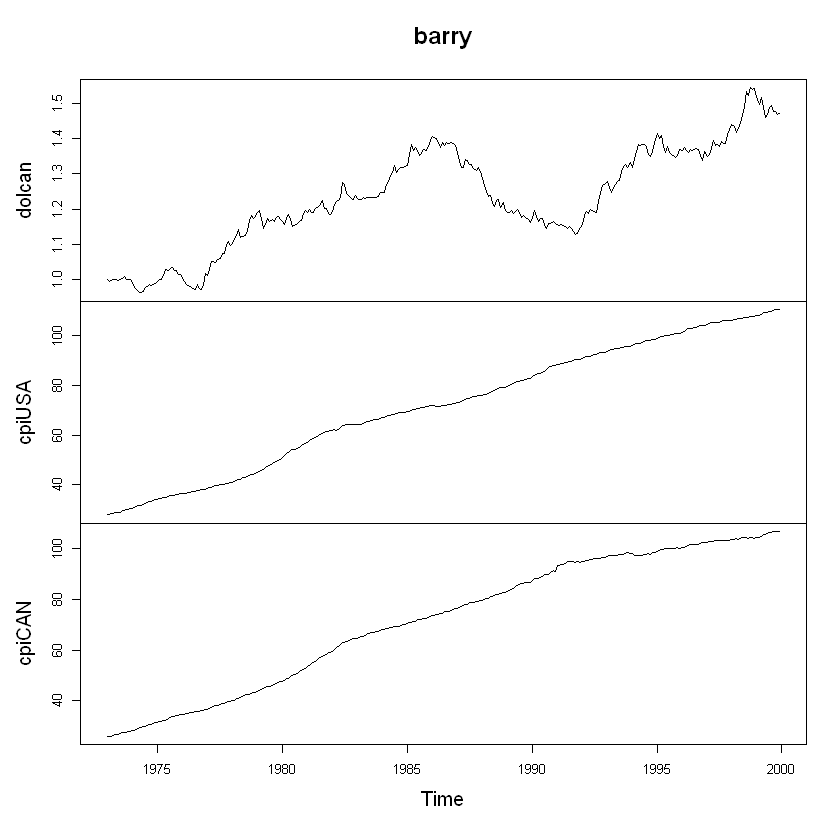

In [19]:
library(tsDyn)
data(barry)
plot(barry)

In [20]:
## For VAR
mod_var <- lineVar(barry, lag = 2)
print(mod_var)

                 Intercept dolcan -1    cpiUSA -1     cpiCAN -1  dolcan -2
Equation dolcan 0.01990322 1.1399804 -0.004066429 -0.0002021078 -0.1609825
Equation cpiUSA 0.24882495 0.5057742  1.473457565 -0.0339894803 -0.5695014
Equation cpiCAN 0.18849724 0.3767774  0.311281524  0.9816315731 -0.2280215
                   cpiUSA -2     cpiCAN -2
Equation dolcan  0.004722663 -0.0003366803
Equation cpiUSA -0.474160066  0.0342943942
Equation cpiCAN -0.316325397  0.0206687371


In [21]:
irf_var = irf(mod_var, impulse = "dolcan", response = c("dolcan", "cpiUSA", "cpiCAN"), boot = FALSE)
# no matter stationary or not, OLS point estimator is always valid
print(irf_var)


Impulse response coefficients
$dolcan
          dolcan        cpiUSA        cpiCAN
 [1,] 0.01276998 -0.0048795134 -0.0125329345
 [2,] 0.01457990 -0.0003050413 -0.0090101859
 [3,] 0.01454930  0.0018422630 -0.0050736143
 [4,] 0.01423393  0.0017779679 -0.0023393791
 [5,] 0.01388787  0.0005650593 -0.0003851082
 [6,] 0.01354745 -0.0011597063  0.0011740840
 [7,] 0.01321540 -0.0030870320  0.0025424613
 [8,] 0.01289057 -0.0050761614  0.0038160907
 [9,] 0.01257198 -0.0070647525  0.0050384137
[10,] 0.01225911 -0.0090256962  0.0062288433
[11,] 0.01195166 -0.0109475037  0.0073960680

$cpiUSA
             dolcan    cpiUSA    cpiCAN
 [1,]  0.0000000000 0.1580981 0.0669699
 [2,] -0.0006564298 0.2306746 0.1149528
 [3,] -0.0009854751 0.2629829 0.1357724
 [4,] -0.0010638945 0.2773202 0.1443263
 [5,] -0.0010147795 0.2836974 0.1474419
 [6,] -0.0009078966 0.2865527 0.1481632
 [7,] -0.0007766471 0.2878444 0.1478363
 [8,] -0.0006361764 0.2884352 0.1470543
 [9,] -0.0004932054 0.2887049 0.1460781
[10,] -0.000

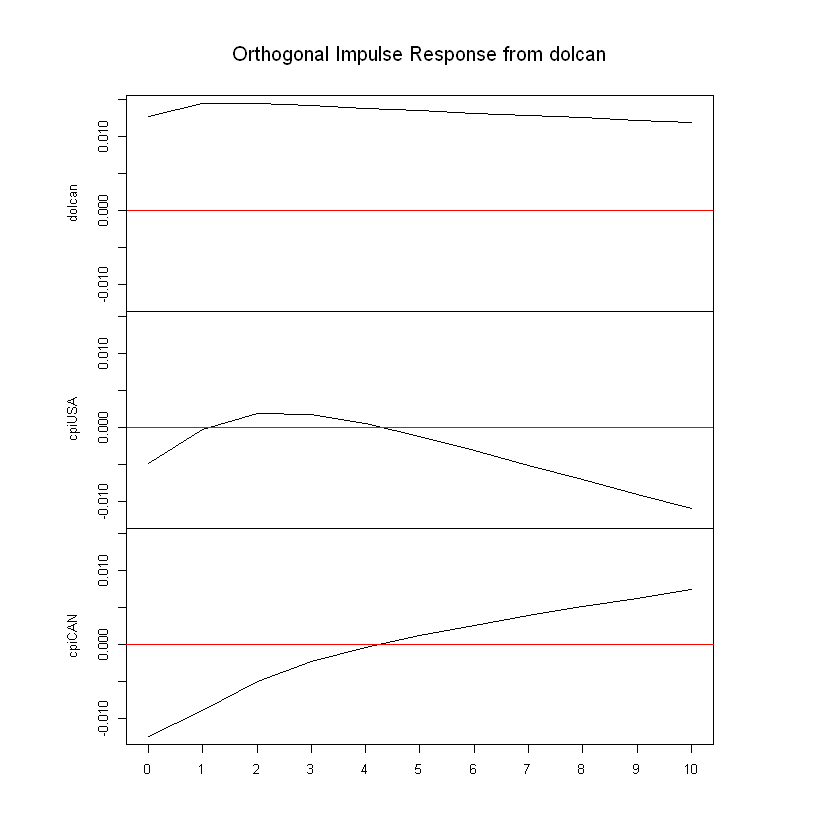

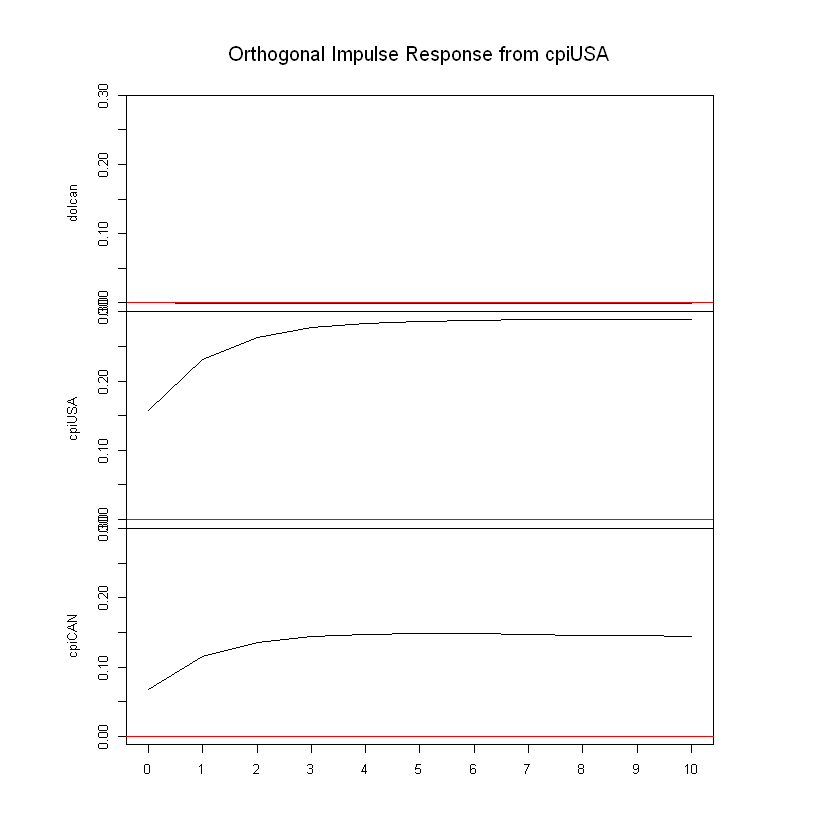

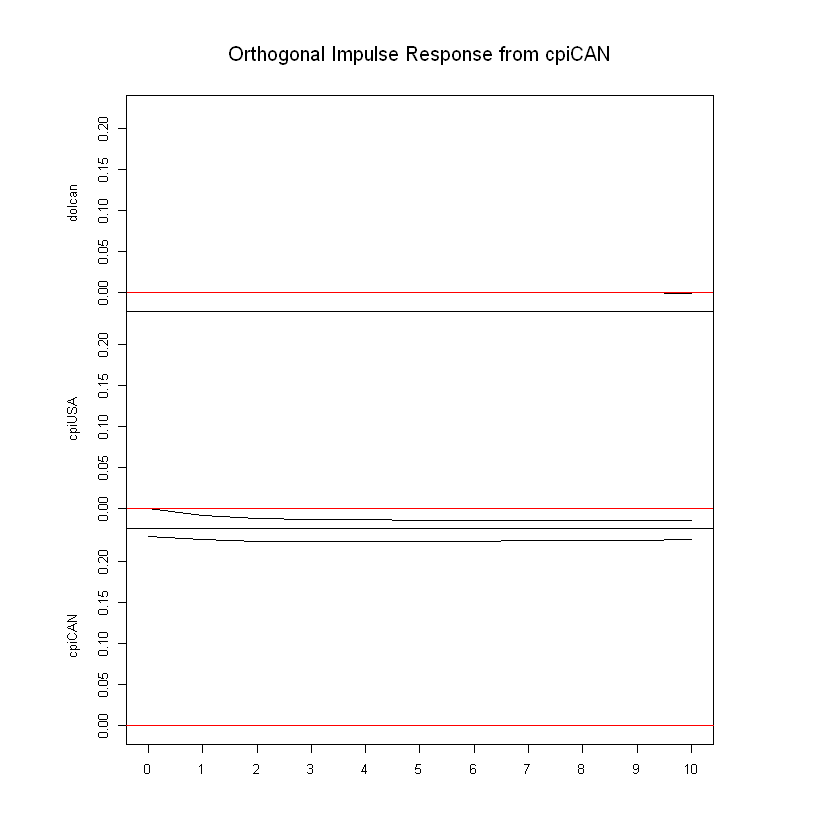

In [22]:
plot(irf_var)

# Structural VAR

* Unrestricted VAR: too many parameters? $m+p\cdot m^2 + m(m+1)/2$
* Use economic theory to reduce the number of unknown parameters

# VECM Representation

Suppose there are $r$ cointegration relationship in $y_t$. For the $m$-equation VAR system 

$$
y_t = \Gamma y_{t-1} + e_t,
$$ 

we can rewrite it as

$$ 
\Delta y_t = (\Gamma - I_m) y_{t-1} + e_t = \Pi y_{t-1} + e_t.
$$

* Since LHS is stationary, the $m\times m$ matrix $\Pi = \Gamma - I_m$ on the RHS must only have rank at most $r$. 
* Otherwise, the RHS will be I(1) and the two sides of the equation are unbalanced.

In [23]:
## For VECM
mod_VECM <- VECM(barry, lag = 2, estim="ML", r=2)
# VECM is better choice for standard inference when nonstationary time series is involved.
print(mod_VECM)
irf_vecm = irf(mod_VECM, impulse = "dolcan", response = c("dolcan", "cpiUSA", "cpiCAN"), boot = FALSE)
print(irf_vecm)

                       ECT1          ECT2  Intercept dolcan -1    cpiUSA -1
Equation dolcan -0.02042246  0.0005673094 0.02193776 0.1631849 -0.003512162
Equation cpiUSA -0.05190423  0.0013970958 0.20996826 0.6604052  0.472999555
Equation cpiCAN  0.12661059 -0.0036778683 0.15127295 0.3462574  0.282921542
                    cpiCAN -1   dolcan -2    cpiUSA -2    cpiCAN -2
Equation dolcan  0.0004160986 -0.03139173 -0.000241599 -0.006599772
Equation cpiUSA -0.0325415257 -0.56714589 -0.025142321  0.076688519
Equation cpiCAN -0.0260677455 -0.33043721  0.013968232  0.170121385

Impulse response coefficients
$dolcan
          dolcan        cpiUSA        cpiCAN
 [1,] 0.01272454 -0.0029721985 -7.489181e-03
 [2,] 0.01455027  0.0036165733 -2.116924e-03
 [3,] 0.01418388 -0.0006990462 -3.454855e-03
 [4,] 0.01375589 -0.0044594440 -2.571368e-03
 [5,] 0.01343874 -0.0070518593 -2.218720e-03
 [6,] 0.01312734 -0.0087977325 -1.107527e-03
 [7,] 0.01281880 -0.0102851047  8.324895e-05
 [8,] 0.01250937 -0.01160

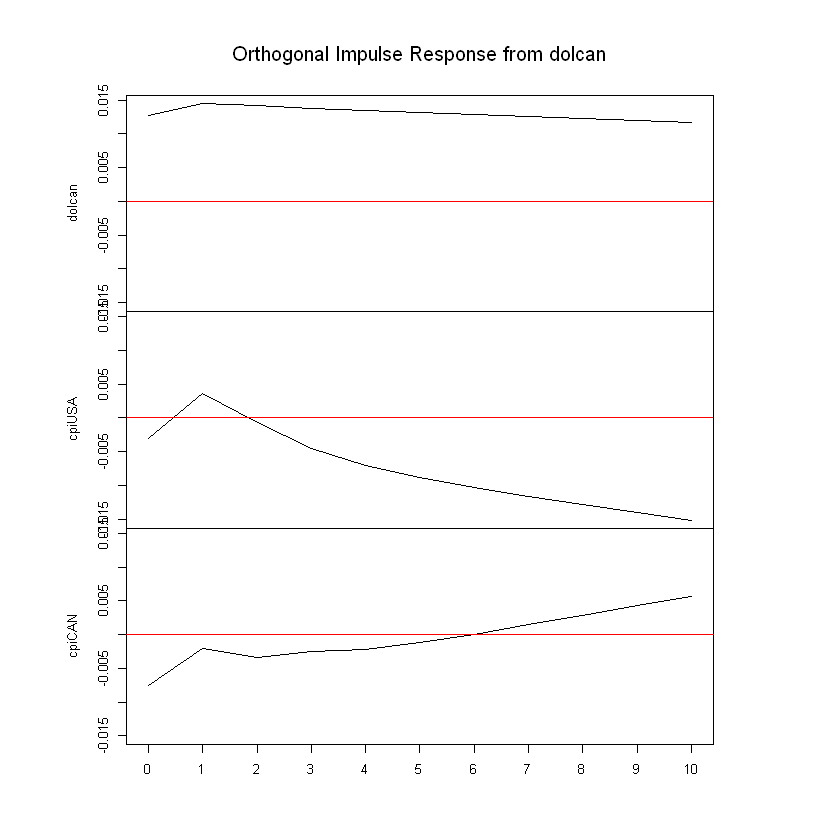

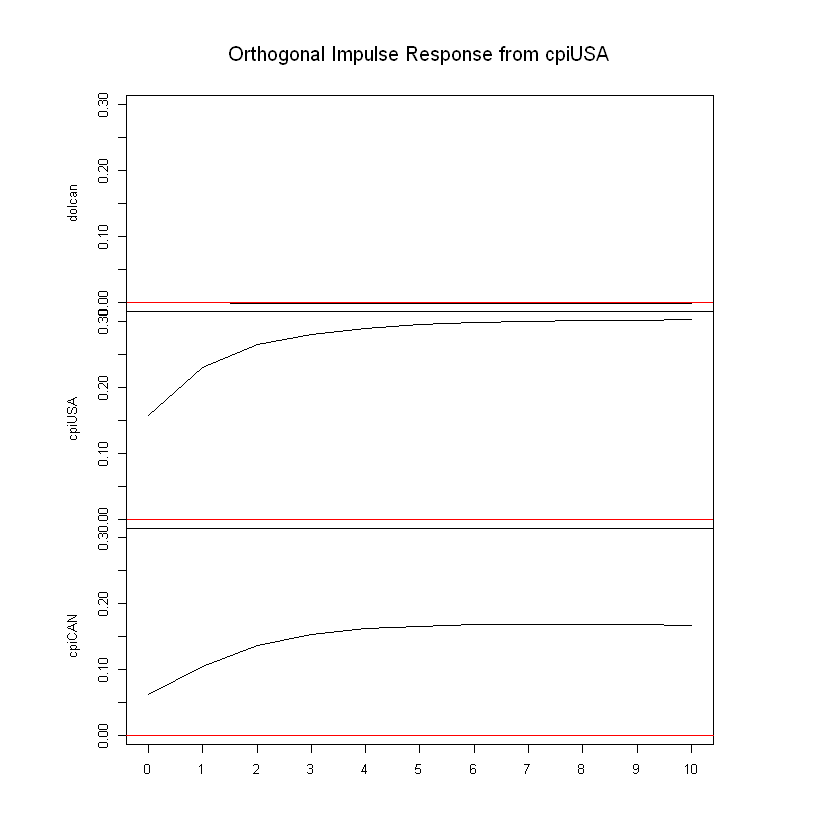

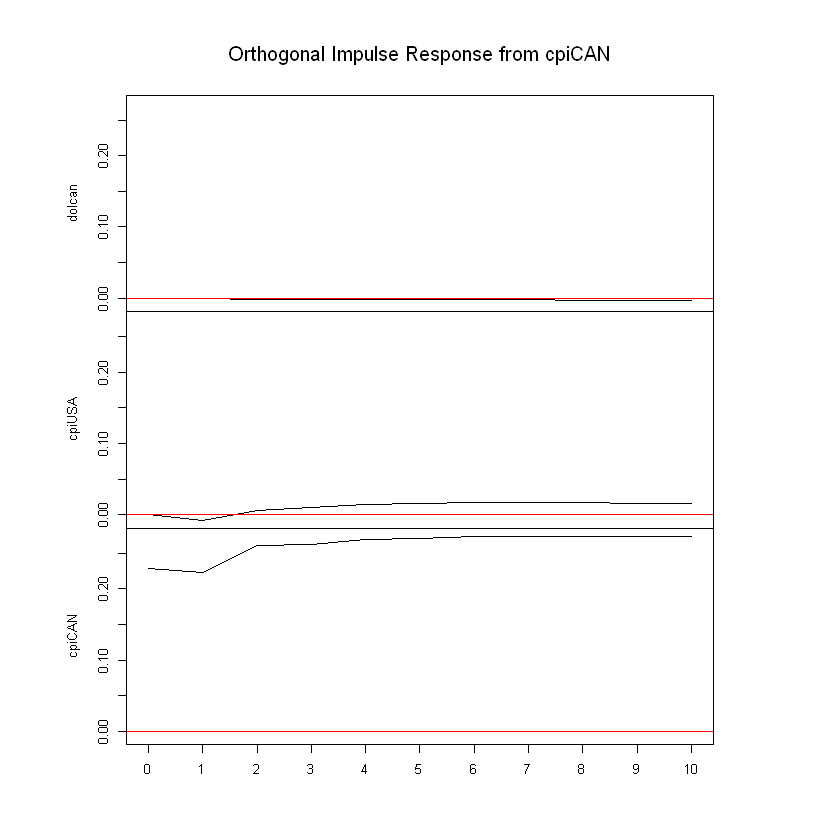

In [25]:
plot(irf_vecm)

# Johansen Test


* VECM is the base for the cointegration rank test (Johansen, 1992).

* Numerical examaple: The result shows that there is only 1 cointegration relationship among the 4 time series.

In [24]:
sjd.vecm = ca.jo(sjd, ecdet = "const", type="eigen", K=2, spec="longrun")
summary(sjd.vecm)
# the result rejects "r = 0", but do not reject "r<=1,2,3"


ERROR: Error in as.matrix(x): object 'sjd' not found


#  Future of Time Series Study

* Classical methods
* Time series model for discrete choice model
* Time series dimension of big data
    * Unstructured data
    * Panel data